In [0]:
import sys
sys.path.append('../')

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from MaskedRNN import MaskedDeepRNN

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
sns.set_style('darkgrid')

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

#### Import, shuffle and split dataset

In [0]:
data = pd.read_csv('reber_sequences.csv')

In [0]:
data = data.sample(frac=1).reset_index(drop=True)

In [0]:
train_data = data[:int(.75*len(data))]
test_data = data[len(train_data):]

In [8]:
print('Total length: {}\nTrain data length: {}\nTest data length: {}'.format(len(data), len(train_data), len(test_data)))

Total length: 25000
Train data length: 18750
Test data length: 6250


#### Parameters

In [0]:
MODEL = 'gru'

In [0]:
BATCH_SIZE = 16

INPUT_SIZE = 128
EMBEDDING_DIM = 100
OUTPUT_SIZE = 2

EPOCHS = 30
HIDDEN_LAYERS = [100, 100, 100]

#### Customize `Dataset`

In [0]:
class MakeDataset(Dataset):
    def __init__(self, data):
        self.strings = list(data['string'])
        self.valid = list(data['valid'])
        self.len = len(self.valid)
        self.valid_list = [0, 1]

    def __getitem__(self, index):
        return self.strings[index], self.valid[index]

    def __len__(self):
        return self.len

#### Train/Test Loader

In [0]:
dataset = MakeDataset(train_data)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
dataset = MakeDataset(test_data)
test_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Helper functions

In [0]:
def create_variable(tensor):
    return Variable(tensor.to(device))

In [0]:
def pad_seq(vect_seqs, seq_lens, valid):
    seq_tensor = torch.zeros((len(vect_seqs), seq_lens.max())).long()
    
    for index, (seq, seq_len) in enumerate(zip(vect_seqs, seq_lens)):
        seq_tensor[index, :seq_len] = torch.LongTensor(seq)
        
    return create_variable(seq_tensor), create_variable(seq_lens), create_variable(valid)

In [0]:
def str2ascii(string):
    ascii_arr = [ord(s) for s in string]
    return ascii_arr, len(ascii_arr)

In [0]:
def make_variables(strings, valid):
    seqs_and_lens = [str2ascii(string)for string in strings]
    vect_seqs = [s[0] for s in seqs_and_lens]
    seq_lens = torch.LongTensor([s[1] for s in seqs_and_lens])
    valid = torch.LongTensor(valid)
    return pad_seq(vect_seqs, seq_lens, valid)

#### Model

In [0]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers: list, mode):
        super(Model, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_layers[0]).to(device)
        self.recurrent = MaskedDeepRNN(hidden_layers[0], hidden_layers, mode=mode).to(device)
        self.fc = nn.Linear(hidden_layers[-1], output_size).to(device)
        
    def forward(self, input):
        input = input.t()
        embedded = self.embedding(input)
        output = self.recurrent(embedded)
        return self.fc(output)

#### Train & Test

In [0]:
def train():
    total_loss = 0
    
    for i, (string, valid) in enumerate(train_loader, 1):
        input, seq_lens, target = make_variables(string, valid)

        output = model(input)
        
        loss = criterion(output, target)
        total_loss += loss.data.item()
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

In [0]:
def test():
    correct = 0.
    test_data_size = len(test_loader.dataset)
    
    for string, valid in test_loader:
        input, seq_lens, target = make_variables(string, valid)

        output = model(input)

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    acc = 100 * correct / test_data_size
        
    print('Accuracy: {:.2f}%\n'.format(acc))
    return acc

#### Pruning

In [0]:
pruned_perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pruned_acc = []

In [0]:
param_dict = torch.load('gru-dict.pt')

In [23]:
for perc in pruned_perc:
    print('Pruned {}%'.format(perc))

    model = Model(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_LAYERS, mode='gru')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    model.load_state_dict(param_dict)
    model.recurrent.set_mask(perc)
        
    train()
    acc = test()
    pruned_acc.append(acc)

Pruned 10%
Accuracy: 100.00%

Pruned 20%
Accuracy: 100.00%

Pruned 30%
Accuracy: 100.00%

Pruned 40%
Accuracy: 100.00%

Pruned 50%
Accuracy: 100.00%

Pruned 60%
Accuracy: 100.00%

Pruned 70%
Accuracy: 100.00%

Pruned 80%
Accuracy: 100.00%

Pruned 90%
Accuracy: 100.00%

Pruned 100%
Accuracy: 50.61%



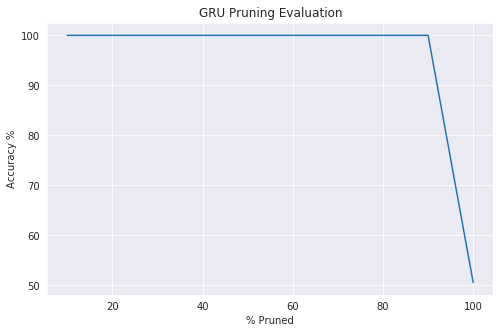

In [24]:
plt.figure(figsize=(8, 5))
plt.title('{} Pruning Evaluation'.format(MODEL.upper()))
plt.xlabel('% Pruned')
plt.ylabel('Accuracy %')
plt.savefig('{}-pruning-acc.png'.format(MODEL))
plt.plot(pruned_perc, pruned_acc);